In [215]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [216]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
path = ''
sys.path.append(path)
import utils
import settings
import pickle
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [217]:
def save(nom,model):
  # Enregistrez le modele (ML/scaler/autre) dans un fichier
  with open(nom+'.pkl', 'wb') as f:
      pickle.dump(model, f)

In [218]:
def f_open(chemin):
  with open(chemin, 'rb') as f:
    modele = pickle.load(f)
  return modele

In [277]:
path = path
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path=path)
test = pd.read_csv(path+"test.csv")
sample_submission = pd.read_csv(path+"sample_submission.csv")

# B and C clean up

In [220]:
def filter_dates_when_constants(df, date_c = 'time', y = 'pv_measurement', delta = { 'days': 3 }):
    df = df.copy()
    mask_y_change = df[y] != df[y].shift(1)

    start_date = None
    end_date = None

    constant_periods = []

    for index, row in df.iterrows():
        if not mask_y_change[index]:
            if start_date is None:
                start_date = row[date_c]
            end_date = row[date_c]
        else:
            if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
                constant_periods.append((start_date, end_date))
            start_date = None
            end_date = None

    if start_date is not None and (end_date - start_date) >= pd.Timedelta(**delta):
        constant_periods.append((start_date, end_date))
    return constant_periods

In [221]:
def delete_date_range_from_df(df, dates, date_c = 'time'):
    df = df.copy()
    c = 0
    for start_date, end_date in dates:
        mask = (df[date_c] >= start_date) & (df[date_c] < end_date)
        df = df[~mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [222]:
delta = { 'hours': 12 * 5}
train_a = delete_date_range_from_df(train_a, filter_dates_when_constants(train_a, delta=delta))
train_b = delete_date_range_from_df(train_b, filter_dates_when_constants(train_b, delta=delta))
train_c = delete_date_range_from_df(train_c, filter_dates_when_constants(train_c, delta=delta))

In [223]:
train_a['date_forecast'] = train_a['time'] - pd.Timedelta(minutes=15)
train_b['date_forecast'] = train_b['time'] - pd.Timedelta(minutes=15)
train_c['date_forecast'] = train_c['time'] - pd.Timedelta(minutes=15)

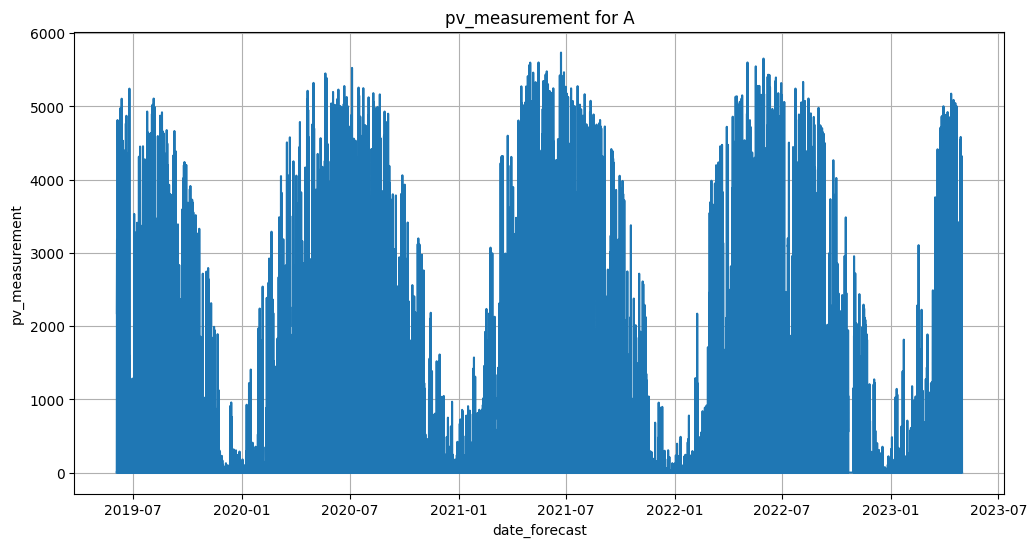

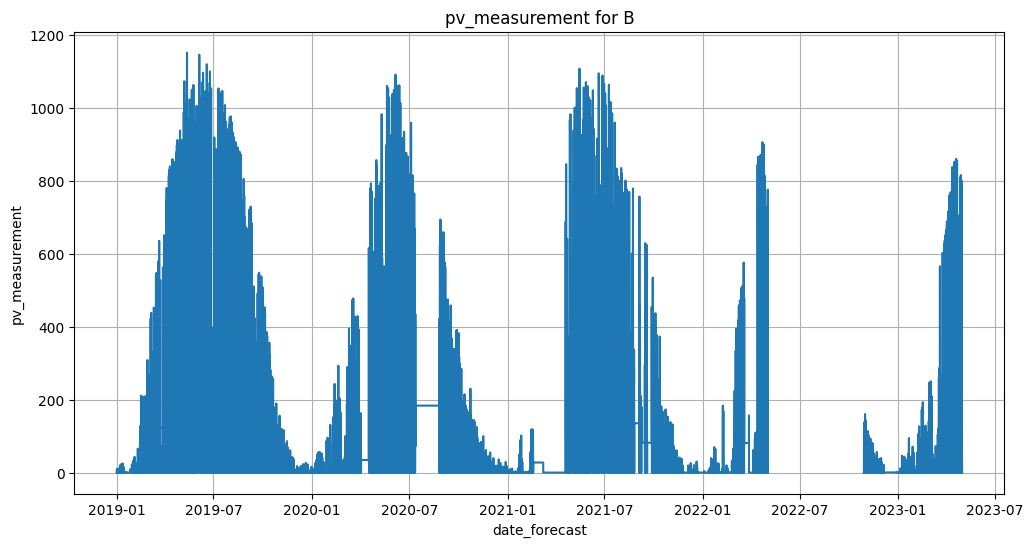

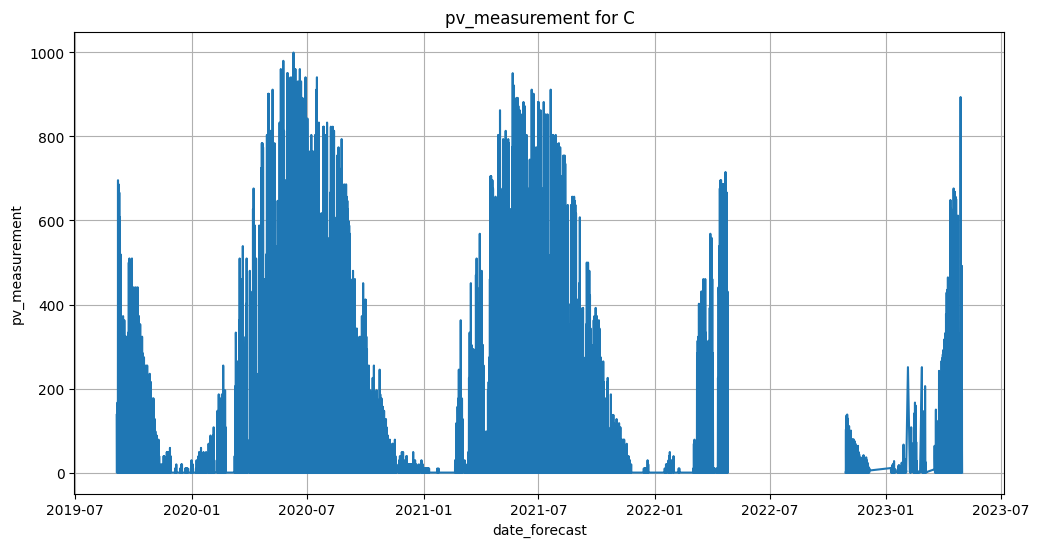

In [224]:
plt.figure(figsize=(12, 6)) 
plt.plot(train_a['time'], train_a['pv_measurement'])
plt.title('pv_measurement for A')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()    

plt.figure(figsize=(12, 6)) 
plt.plot(train_b['time'], train_b['pv_measurement'])
plt.title('pv_measurement for B')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()    

plt.figure(figsize=(12, 6)) 
plt.plot(train_c['time'], train_c['pv_measurement'])
plt.title('pv_measurement for C')
plt.xlabel('date_forecast') 
plt.ylabel('pv_measurement')
plt.grid(True)
plt.show()   

# Réorganisation des df :

In [225]:
# observed + estimated
X_total_a = pd.concat([X_train_observed_a,X_train_estimated_a])
X_total_b = pd.concat([X_train_observed_b,X_train_estimated_b])
X_total_c = pd.concat([X_train_observed_c,X_train_estimated_c])

Attention, il faut penser à revoir les valeurs météo et pv de estimated !!!

# Changement nom time dans les train

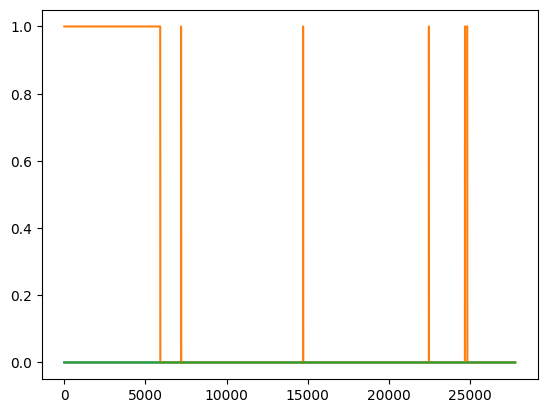

In [226]:
plt.plot(train_c.isna())

In [227]:
# train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
# test.rename(columns={'time': 'date_forecast'}, inplace=True)
train_a, train_b, train_c = train_a.drop(columns='time'), train_b.drop(columns='time'), train_c.drop(columns='time')
train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

# Correspondance X et y :

Ici nous avons plusieurs choix :    
- matcher directement sur dateforcast
- matcher sur dateforcast et résumer nos variables météo en moyenne et écart type
- matcher sur un autre créneau (peut être fais sur des variables spécifique !)

Dans un premier temps on fera directement sur dateforcast

In [228]:
X_total_a_y = pd.merge(X_total_a, train_a, on='date_forecast', how='inner')
X_total_b_y = pd.merge(X_total_b, train_b, on='date_forecast', how='inner')
X_total_c_y = pd.merge(X_total_c, train_c, on='date_forecast', how='inner')

# Analyse des Nan

In [229]:
X_train_observed_a['snow_density:kgm3'].isna().sum()/len(X_train_observed_a)

0.9770453951748139

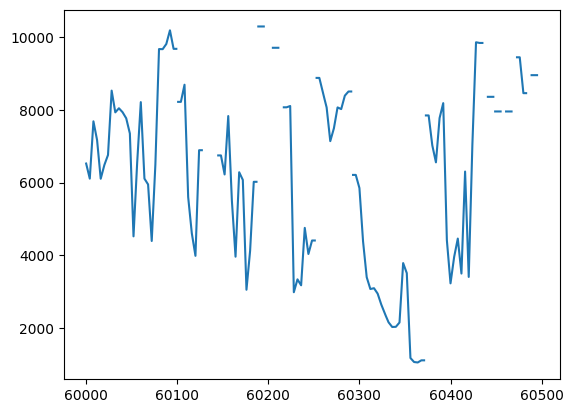

In [230]:
plt.plot(X_train_observed_a['ceiling_height_agl:m'][60000:60500])
#.plot(X_train_observed_a_nan['ceiling_height_agl:m'][60000:60500],ls="--")
#plt.plot(X_train_observed_a['cloud_base_agl:m'][60000:62000].isna())

In [231]:
X_train_observed_a.isna().sum(axis=0)/len(X_train_observed_a)

date_forecast                     0.000000
absolute_humidity_2m:gm3          0.000000
air_density_2m:kgm3               0.000000
ceiling_height_agl:m              0.187471
clear_sky_energy_1h:J             0.000000
clear_sky_rad:W                   0.000000
cloud_base_agl:m                  0.067971
dew_or_rime:idx                   0.000000
dew_point_2m:K                    0.000000
diffuse_rad:W                     0.000000
diffuse_rad_1h:J                  0.000000
direct_rad:W                      0.000000
direct_rad_1h:J                   0.000000
effective_cloud_cover:p           0.000000
elevation:m                       0.000000
fresh_snow_12h:cm                 0.000000
fresh_snow_1h:cm                  0.000000
fresh_snow_24h:cm                 0.000000
fresh_snow_3h:cm                  0.000000
fresh_snow_6h:cm                  0.000000
is_day:idx                        0.000000
is_in_shadow:idx                  0.000000
msl_pressure:hPa                  0.000000
precip_5min

**Conclusion** de l'analyse :    
- Il y a 3 variables avec des Nan
- Snow density est vide à 98% on la supprime
- les deux autres sont vide à 7 et 19% et ce sont des points manquant (problème dans la prise de mesure probablement)
- on décide donc de les compléter par prolongement (moyenne des points environnant)

In [232]:
def gestion_nan(df):
  df_copy = df.copy()
  #delete of the snow density column
  df_copy = df_copy.drop('snow_density:kgm3',axis=1)
  # Approximation of the other two columns
  df_copy['ceiling_height_agl:m'] = df_copy['ceiling_height_agl:m'].interpolate(method='linear', limit_direction='both')
  df_copy['cloud_base_agl:m'] = df_copy['cloud_base_agl:m'].interpolate(method='linear', limit_direction='both')
  return df_copy

In [233]:
X_train_observed_a_nan = gestion_nan(X_train_observed_a)

In [234]:
X_train_observed_a_nan.isna().sum(axis=0)/len(X_train_observed_a_nan)

date_forecast                     0.0
absolute_humidity_2m:gm3          0.0
air_density_2m:kgm3               0.0
ceiling_height_agl:m              0.0
clear_sky_energy_1h:J             0.0
clear_sky_rad:W                   0.0
cloud_base_agl:m                  0.0
dew_or_rime:idx                   0.0
dew_point_2m:K                    0.0
diffuse_rad:W                     0.0
diffuse_rad_1h:J                  0.0
direct_rad:W                      0.0
direct_rad_1h:J                   0.0
effective_cloud_cover:p           0.0
elevation:m                       0.0
fresh_snow_12h:cm                 0.0
fresh_snow_1h:cm                  0.0
fresh_snow_24h:cm                 0.0
fresh_snow_3h:cm                  0.0
fresh_snow_6h:cm                  0.0
is_day:idx                        0.0
is_in_shadow:idx                  0.0
msl_pressure:hPa                  0.0
precip_5min:mm                    0.0
precip_type_5min:idx              0.0
pressure_100m:hPa                 0.0
pressure_50m

# Traitement des df + séparation train/test

## Séparation train/test

A la fin on va projeter à partir de donnée météo estimer sur un periode non rencontré.

On va donc séparer notre train/test sur les même conditions, à savoir que le test sera issue de estimated. Il ne reste qu'à fixer la date à partir de laquelle on fait la séparation.

L'objectif est aussi d'avoir de l'estimated dans l'entrainement pour prendre en compte la différence entre observed et estimated qui devra être régler plus tard.

In [235]:
print(len(X_train_observed_a))
print(len(X_train_estimated_a))
print(len(X_train_estimated_a)/(len(X_train_estimated_a)+len(X_train_observed_a)))

118669
17576
0.12900289918896107


In [236]:
X_total_a_y_nan = gestion_nan(X_total_a_y)
X_total_b_y_nan = gestion_nan(X_total_b_y)
X_total_c_y_nan = gestion_nan(X_total_c_y)

In [237]:
split_date_a = X_train_estimated_a['date_forecast'].quantile(0.25)
split_date_b = X_train_estimated_b['date_forecast'].quantile(0.25)
split_date_c = X_train_estimated_c['date_forecast'].quantile(0.25)

In [238]:
split_date_a = pd.to_datetime("2021-04-15")
split_date2_a = pd.to_datetime("2021-08-15")

split_date_b = pd.to_datetime("2019-04-15")
split_date2_b = pd.to_datetime("2019-08-15")

split_date_c = pd.to_datetime("2021-04-15")
split_date2_c = pd.to_datetime("2021-08-15")

In [279]:
train_a[train_a['time'] == split_date2_a]

,time,pv_measurement
19298,2021-08-15,0.0


In [239]:
# on coupe nos dataframe à une certaine date

# pv_train_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] <= split_date_a].copy()
# pv_test_a = X_total_a_y_nan[X_total_a_y_nan['date_forecast'] > split_date_a].copy()

# pv_train_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] <= split_date_b].copy()
# pv_test_b = X_total_b_y_nan[X_total_b_y_nan['date_forecast'] > split_date_b].copy()

# pv_train_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] <= split_date_c].copy()
# pv_test_c = X_total_c_y_nan[X_total_c_y_nan['date_forecast'] > split_date_c].copy()

mask_train_a = (X_total_a_y_nan['date_forecast'] <= split_date_a) | (X_total_a_y_nan['date_forecast'] > split_date2_a)

pv_train_a = X_total_a_y_nan[(X_total_a_y_nan['date_forecast'] <= split_date_a) | (X_total_a_y_nan['date_forecast'] > split_date2_a)].copy()
pv_test_a = X_total_a_y_nan[(X_total_a_y_nan['date_forecast'] > split_date_a) & (X_total_a_y_nan['date_forecast'] <= split_date2_a)].copy()

pv_train_b = X_total_b_y_nan[(X_total_b_y_nan['date_forecast'] <= split_date_b) | (X_total_b_y_nan['date_forecast'] > split_date2_b)].copy()
pv_test_b = X_total_b_y_nan[(X_total_b_y_nan['date_forecast'] > split_date_b) & (X_total_b_y_nan['date_forecast'] <= split_date2_b)].copy()

pv_train_c = X_total_c_y_nan[(X_total_c_y_nan['date_forecast'] <= split_date_c) | (X_total_c_y_nan['date_forecast'] > split_date2_c)].copy()
pv_test_c = X_total_c_y_nan[(X_total_c_y_nan['date_forecast'] > split_date_c) & (X_total_c_y_nan['date_forecast'] <= split_date2_c)].copy()


print("train_a :",pv_train_a.shape)
print("test_a :",pv_test_a.shape)
print("Rapport test/total :", round(pv_test_a.shape[0]/(pv_test_a.shape[0]+pv_train_a.shape[0]),3)*100)
print("train_b :",pv_train_b.shape)
print("test_b :",pv_test_b.shape)
print("Rapport test/total :", round(pv_test_b.shape[0]/(pv_test_b.shape[0]+pv_train_b.shape[0]),3)*100)
print("train_c :",pv_train_c.shape)
print("test_c :",pv_test_c.shape)
print("Rapport test/total :", round(pv_test_c.shape[0]/(pv_test_c.shape[0]+pv_train_c.shape[0]),3)*100)

train_a : (31116, 47)
test_a : (2928, 47)
Rapport test/total : 8.6
train_b : (24309, 47)
test_b : (2852, 47)
Rapport test/total : 10.5
train_c : (18773, 47)
test_c : (2928, 47)
Rapport test/total : 13.5


## Changement type de la date_forecast

In [240]:
# on change le type de date_forecast
pv_train_a['date_forecast'] = pd.to_datetime(pv_train_a['date_forecast'])
pv_test_a['date_forecast'] = pd.to_datetime(pv_test_a['date_forecast'])

pv_train_b['date_forecast'] = pd.to_datetime(pv_train_b['date_forecast'])
pv_test_b['date_forecast'] = pd.to_datetime(pv_test_b['date_forecast'])

pv_train_c['date_forecast'] = pd.to_datetime(pv_train_c['date_forecast'])
pv_test_c['date_forecast'] = pd.to_datetime(pv_test_c['date_forecast'])

## Filtrage des variables

In [241]:
pv_train_a.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm',
       'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d',
       'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p',
       'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms',
       'wind_speed_v_10m:ms

In [242]:
#function to apply XGBoost model
def create_features(df, label):

    # V2
    df['hour'] = df["date_forecast"].dt.hour
    df['dayofweek'] = df["date_forecast"].dt.dayofweek
    df['quarter'] = df["date_forecast"].dt.quarter
    df['month'] = df["date_forecast"].dt.month
    df['year'] = df["date_forecast"].dt.year
    df['dayofyear'] = df["date_forecast"].dt.dayofyear
    df['dayofmonth'] = df["date_forecast"].dt.day
    # fin V2
    df = df.drop(["date_calc","date_forecast"],axis=1) # date de calcul des estimated inutil pour l'instant
    if label:
        y = df[label]
        df = df.drop(label,axis=1)
        return df, y
    return df

In [243]:
X_train_a, y_train_a = create_features(pv_train_a, label='pv_measurement')
X_test_a, y_test_a = create_features(pv_test_a, label='pv_measurement')

X_train_b, y_train_b = create_features(pv_train_b, label='pv_measurement')
X_test_b, y_test_b = create_features(pv_test_b, label='pv_measurement')

X_train_c, y_train_c = create_features(pv_train_c, label='pv_measurement')
X_test_c, y_test_c = create_features(pv_test_c, label='pv_measurement')

## Conversion du type de la date

In [244]:
# X_train_a[('date_forecast')] = X_train_a[('date_forecast')].values.astype("float64")
# X_train_b[('date_forecast')] = X_train_b[('date_forecast')].values.astype("float64")
# X_train_c[('date_forecast')] = X_train_c[('date_forecast')].values.astype("float64")
# X_test_a[('date_forecast')] = X_test_a[('date_forecast')].values.astype("float64")
# X_test_b[('date_forecast')] = X_test_b[('date_forecast')].values.astype("float64")
# X_test_c[('date_forecast')] = X_test_c[('date_forecast')].values.astype("float64")

## Normalisation

In [245]:
from sklearn.preprocessing import Normalizer, RobustScaler

def sklearn_z_score_normalize_dataframe(df,return_scaler=False,scaler=None):
    """
    Normalizes a DataFrame using z-score normalization (mean and standard deviation) from Scikit-Learn.

    Parameters:
    df (pd.DataFrame): The DataFrame to be normalized.

    Returns:
    pd.DataFrame: The z-score normalized DataFrame.
    """
    if scaler == None :
      # Create a StandardScaler instance
      # scaler = Normalizer()
      # scaler = RobustScaler()
      scaler = StandardScaler()

      # Fit the scaler on the DataFrame and transform the data
      normalized_data = scaler.fit_transform(df)

    else : normalized_data = scaler.transform(df)

    # Create a new DataFrame with the scaled data
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

    # retourner le scaler
    if return_scaler :
      return normalized_df,scaler
    return normalized_df

In [246]:
X_train_a

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
0,7.7,1.226,1713.400024,0.000000,0.000000,1713.400024,0.0,280.299988,0.000000,0.000000,0.0,0.000000,99.400002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.799988,0.0,0.0,993.299988,999.299988,0.0,0.0,70.199997,1005.299988,0.0,0.0,-0.0,0.2,353.251007,-4.247,0.0,286.600006,100.000000,41153.601562,3.5,-3.5,-0.2,-0.0,22,6,2,6,2019,153,2
1,7.7,1.222,1676.400024,0.000000,0.000000,1676.400024,0.0,280.299988,0.000000,0.000000,0.0,0.000000,99.900002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.900024,0.0,0.0,992.299988,998.299988,0.0,0.1,66.800003,1004.299988,0.0,0.0,-0.0,0.2,7.218000,-4.219,0.0,287.000000,100.000000,25819.500000,3.2,-3.2,0.5,-0.0,23,6,2,6,2019,153,2
2,8.1,1.219,1458.300049,0.000000,0.000000,1458.300049,0.0,281.100006,0.000000,0.000000,0.0,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.400024,0.0,0.0,991.900024,997.900024,0.0,0.1,69.900002,1003.799988,0.0,0.0,-0.0,0.6,20.115000,-2.611,0.0,286.899994,100.000000,6711.200195,2.9,-2.8,0.8,-0.0,0,0,2,6,2019,154,3
3,8.6,1.218,1178.500000,834.599976,3.000000,1178.500000,0.0,282.000000,1.200000,2107.100098,0.0,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1003.700012,0.0,0.0,991.200012,997.099976,0.0,0.1,76.599998,1003.099976,0.0,0.0,-0.0,0.4,33.698002,0.428,0.0,286.600006,100.000000,2539.000000,2.7,-2.5,0.9,-0.0,1,0,2,6,2019,154,3
4,9.1,1.217,898.500000,66482.000000,38.700001,898.500000,0.0,282.700012,20.799999,39584.898438,0.6,1131.900024,69.500000,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1002.799988,0.0,0.0,990.200012,996.099976,0.0,0.1,81.400002,1002.099976,0.0,0.0,-0.0,0.2,46.933998,4.773,0.0,286.399994,98.000000,20599.199219,2.4,-2.2,0.9,-0.0,2,0,2,6,2019,154,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34039,4.6,1.275,1759.900024,227945.500000,25.299999,546.200012,0.0,272.500000,15.300000,127061.398438,1.1,58343.398438,96.000000,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1014.700012,0.0,0.0,1001.500000,1007.700012,0.0,0.0,73.099998,1014.000000,0.0,0.0,-0.0,0.0,296.571991,3.394,0.0,275.299988,96.000000,24430.599609,5.5,5.2,1.8,-0.0,18,6,2,4,2023,120,30
34040,4.5,1.278,1715.400024,26052.800781,0.000000,537.900024,0.0,272.299988,0.000000,27537.500000,0.0,1976.500000,95.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1014.799988,0.0,0.0,1001.599976,1007.799988,0.0,0.0,75.800003,1014.099976,0.0,0.0,-0.0,0.0,310.002991,-2.217,0.0,274.799988,95.000000,21219.199219,4.9,4.5,2.0,-0.0,19,6,2,4,2023,120,30
34041,4.5,1.280,1781.900024,0.000000,0.000000,558.099976,0.0,272.299988,0.000000,0.000000,0.0,0.000000,93.900002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1014.599976,0.0,0.0,1001.500000,1007.700012,0.0,0.0,77.199997,1014.000000,0.0,0.0,-0.0,0.0,323.859009,-6.803,0.0,274.600006,94.500000,22407.400391,4.6,3.8,2.5,-0.0,20,6,2,4,2023,120,30
34042,4.5,1.281,1598.400024,0.000000,0.000000,530.799988,0.0,272.299988,0.000000,0.000000,0.0,0.000000,95.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1014.500000,0.0,0.0,1001.400024,1007.599976,0.0,0.0,78.099998,1013.900024,0.0,0.0,-0.0,0.0,338.199005,-10.056,0.0,274.500000,96.800003,18304.699219,4.4,3.5,2.6,-0.

In [247]:
X_train_a_norm,scaler_a = sklearn_z_score_normalize_dataframe(X_train_a,return_scaler=True)
X_train_b_norm,scaler_b = sklearn_z_score_normalize_dataframe(X_train_b,return_scaler=True)
X_train_c_norm,scaler_c = sklearn_z_score_normalize_dataframe(X_train_c,return_scaler=True)

In [248]:
X_test_a_norm = sklearn_z_score_normalize_dataframe(X_test_a,return_scaler=False,scaler=scaler_a)
X_test_b_norm = sklearn_z_score_normalize_dataframe(X_test_b,return_scaler=False,scaler=scaler_b)
X_test_c_norm = sklearn_z_score_normalize_dataframe(X_test_c,return_scaler=False,scaler=scaler_c)

## Preprocessing globale

faire un code qui reprend toute les étapes ci dessus pour éviter de faire plein de lignes qui  se répêtes !!!

# Partie XBGoost de base (Nahel)

In [249]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

In [250]:
# Créez un modèle XGBoost
reg_a = xgb.XGBRegressor(n_estimators=10000)

# Entraînez le modèle et suivez l'évolution des erreurs
reg_a.fit(X_train_a_norm, y_train_a,
          eval_set=[(X_train_a_norm, y_train_a), (X_test_a_norm, y_test_a)],
          early_stopping_rounds=50,
          verbose=True)

reg_b = xgb.XGBRegressor(n_estimators=10000)
reg_b.fit(X_train_b_norm, y_train_b,
          eval_set=[(X_train_b_norm, y_train_b), (X_test_b_norm, y_test_b)],
          early_stopping_rounds=50,
          verbose=True)

reg_c = xgb.XGBRegressor(n_estimators=10000)
reg_c.fit(X_train_c_norm, y_train_c,
          eval_set=[(X_train_c_norm, y_train_c), (X_test_c_norm, y_test_c)],
          early_stopping_rounds=50,
          verbose=True)

[0]	validation_0-rmse:832.79162	validation_1-rmse:1371.34049
[1]	validation_0-rmse:664.68940	validation_1-rmse:1102.36476
[2]	validation_0-rmse:558.75114	validation_1-rmse:925.11651
[3]	validation_0-rmse:490.95637	validation_1-rmse:816.74082
[4]	validation_0-rmse:451.38363	validation_1-rmse:752.22584
[5]	validation_0-rmse:425.69067	validation_1-rmse:708.95246
[6]	validation_0-rmse:408.92420	validation_1-rmse:684.04089
[7]	validation_0-rmse:396.98282	validation_1-rmse:671.38783
[8]	validation_0-rmse:386.82089	validation_1-rmse:664.54511
[9]	validation_0-rmse:378.55018	validation_1-rmse:657.77465
[10]	validation_0-rmse:373.45301	validation_1-rmse:653.87882
[11]	validation_0-rmse:366.44822	validation_1-rmse:649.95915
[12]	validation_0-rmse:360.40170	validation_1-rmse:647.76680
[13]	validation_0-rmse:354.32106	validation_1-rmse:651.88823
[14]	validation_0-rmse:350.50656	validation_1-rmse:653.35345
[15]	validation_0-rmse:346.34069	validation_1-rmse:652.86871
[16]	validation_0-rmse:342.85837

[41]	validation_0-rmse:277.42193	validation_1-rmse:657.62965
[42]	validation_0-rmse:276.61875	validation_1-rmse:658.47781
[43]	validation_0-rmse:274.74161	validation_1-rmse:659.40539


/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-rmse:273.88069	validation_1-rmse:659.84617
[45]	validation_0-rmse:271.31473	validation_1-rmse:661.45645
[46]	validation_0-rmse:269.58892	validation_1-rmse:661.46834
[47]	validation_0-rmse:268.32870	validation_1-rmse:662.28970
[48]	validation_0-rmse:265.91836	validation_1-rmse:661.77419
[49]	validation_0-rmse:264.05479	validation_1-rmse:662.80308
[50]	validation_0-rmse:262.27253	validation_1-rmse:663.11800
[51]	validation_0-rmse:260.34738	validation_1-rmse:664.07146
[52]	validation_0-rmse:258.22487	validation_1-rmse:664.90914
[53]	validation_0-rmse:257.47366	validation_1-rmse:665.13561
[54]	validation_0-rmse:256.24737	validation_1-rmse:665.64202
[55]	validation_0-rmse:254.85904	validation_1-rmse:665.68277
[56]	validation_0-rmse:252.92486	validation_1-rmse:667.32627
[57]	validation_0-rmse:252.01057	validation_1-rmse:667.47365
[58]	validation_0-rmse:249.89810	validation_1-rmse:667.43482
[59]	validation_0-rmse:248.72930	validation_1-rmse:667.61081
[60]	validation_0-rmse:2

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[51]	validation_0-rmse:33.06689	validation_1-rmse:129.67223
[52]	validation_0-rmse:32.71347	validation_1-rmse:129.64338
[53]	validation_0-rmse:32.34964	validation_1-rmse:130.05176
[54]	validation_0-rmse:31.87549	validation_1-rmse:130.18009
[55]	validation_0-rmse:31.52764	validation_1-rmse:130.41902
[56]	validation_0-rmse:31.37276	validation_1-rmse:130.45356
[57]	validation_0-rmse:31.23988	validation_1-rmse:130.38860
[58]	validation_0-rmse:31.12563	validation_1-rmse:130.36739
[59]	validation_0-rmse:30.94444	validation_1-rmse:130.38949
[60]	validation_0-rmse:30.84453	validation_1-rmse:130.54227
[61]	validation_0-rmse:30.66716	validation_1-rmse:130.58908
[62]	validation_0-rmse:30.30190	validation_1-rmse:130.51861
[63]	validation_0-rmse:30.02788	validation_1-rmse:130.51951
[64]	validation_0-rmse:29.75268	validation_1-rmse:130.61462
[65]	validation_0-rmse:29.43041	validation_1-rmse:130.60371
[66]	validation_0-rmse:29.16867	validation_1-rmse:130.69685
[0]	validation_0-rmse:116.75848	validati

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

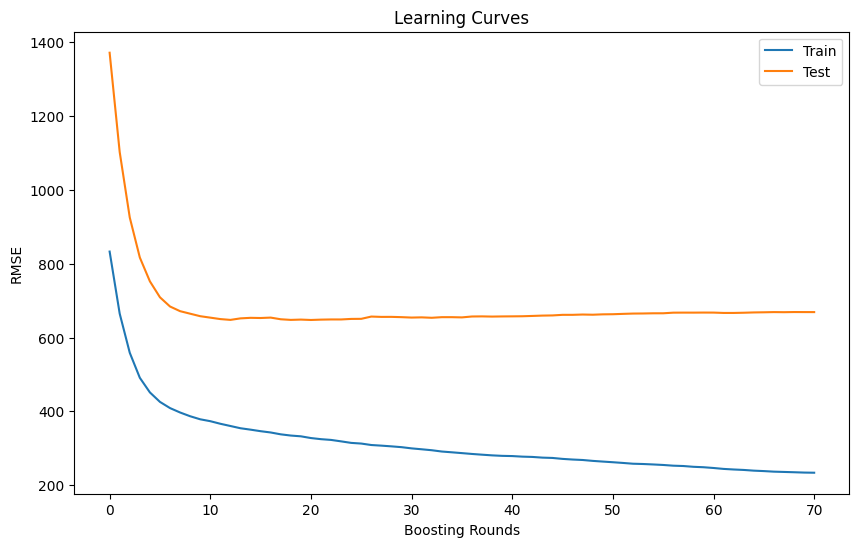

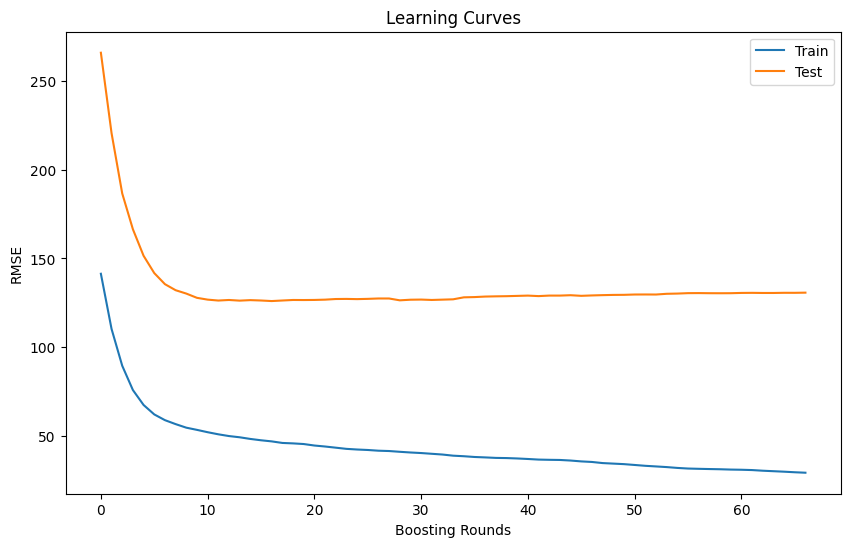

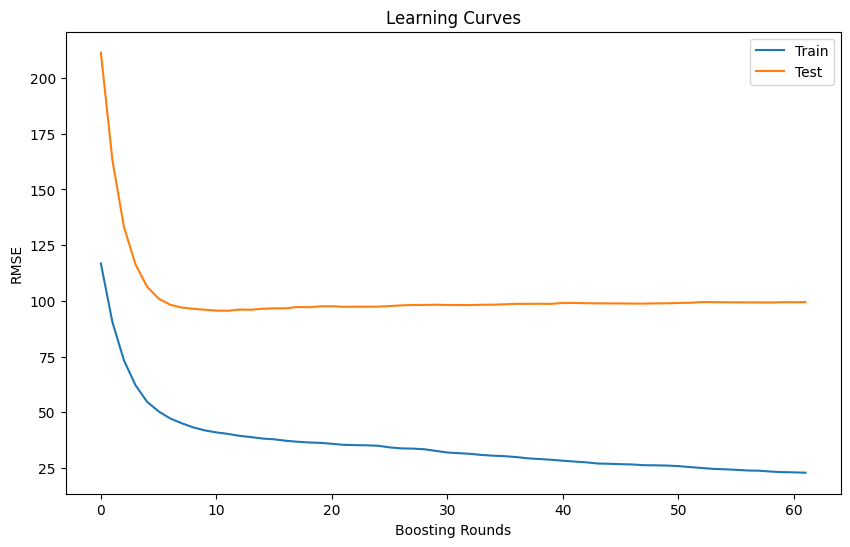

In [251]:
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_a.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_a = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_b.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

min_error_b = min(test_errors)
# Créez des listes vides pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Accédez aux erreurs d'entraînement et de test après chaque itération
results = reg_c.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

min_error_c = min(test_errors)
# Tracez les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

In [252]:
min_error_a, min_error_b, min_error_c

(647.5395915306673, 125.95977536772632, 95.54095185479513)

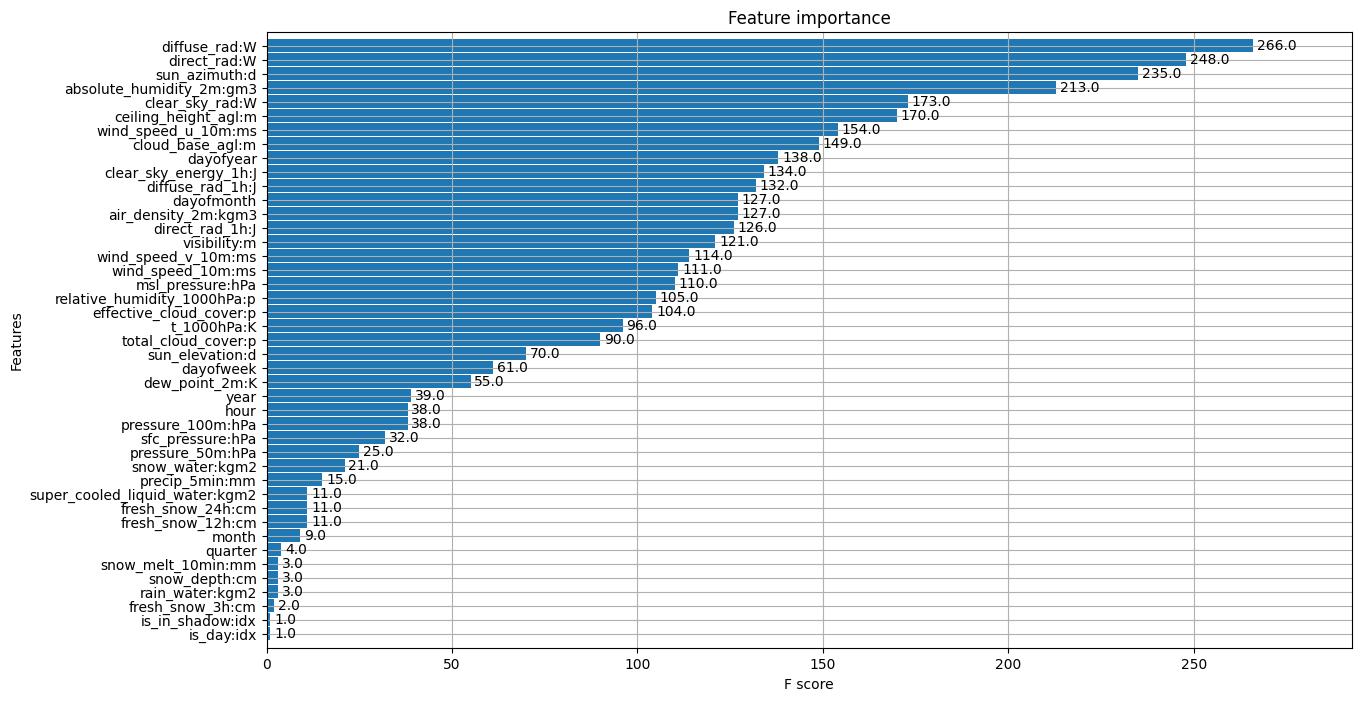

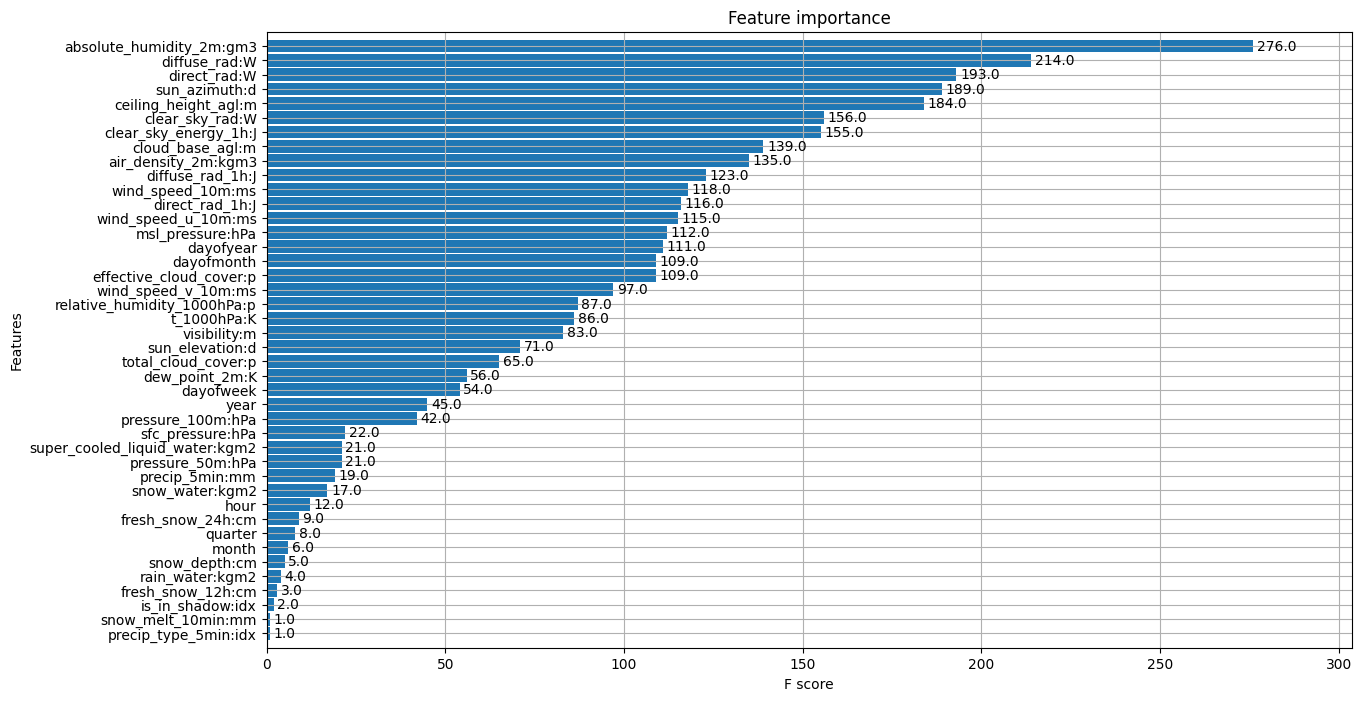

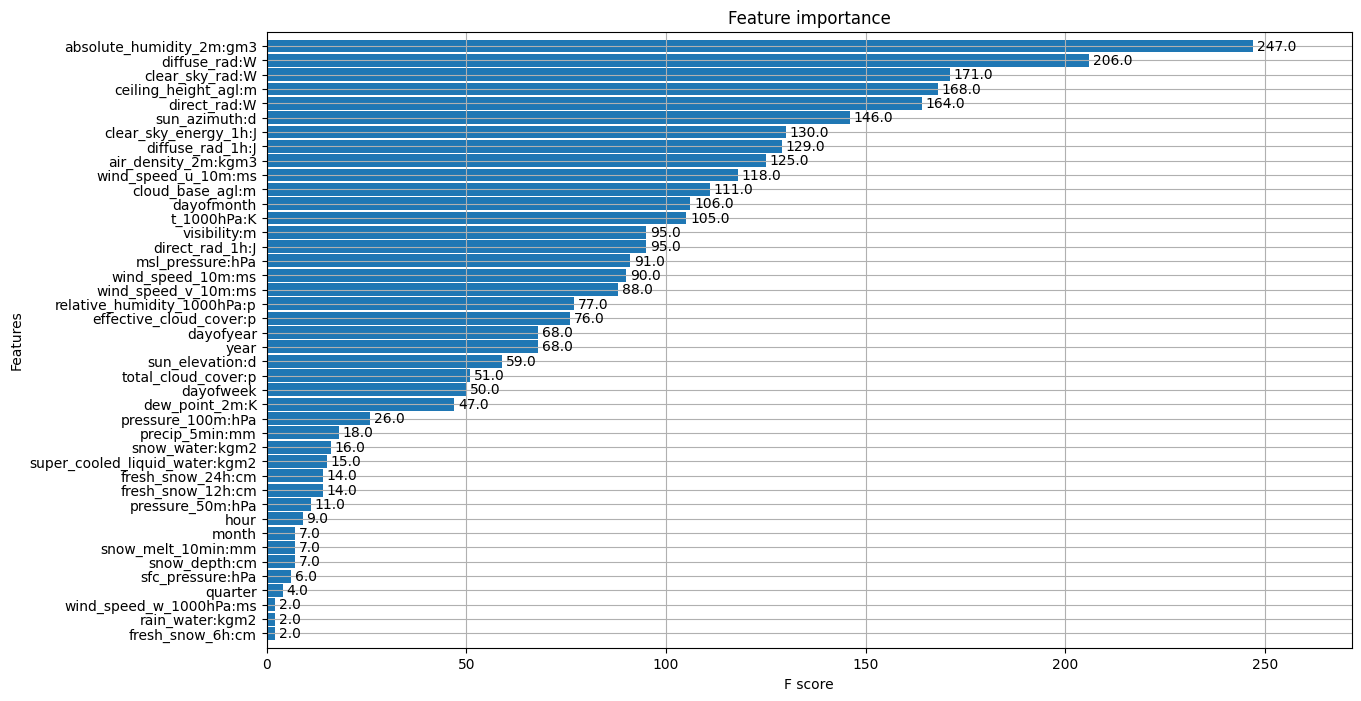

In [253]:
plot_importance(reg_a, height=.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_b, height=0.9)
plt.gcf().set_size_inches(14, 8)
plot_importance(reg_c, height=0.9)
plt.gcf().set_size_inches(14, 8)

In [254]:
pv_test_a['pv_measurement_prediction'] = reg_a.predict(X_test_a_norm)
pv_all_a = pd.concat([pv_test_a, pv_train_a], sort=False)

pv_test_b['pv_measurement_prediction'] = reg_b.predict(X_test_b_norm)
pv_all_b = pd.concat([pv_test_b, pv_train_b], sort=False)

pv_test_c['pv_measurement_prediction'] = reg_c.predict(X_test_c_norm)
pv_all_c = pd.concat([pv_test_c, pv_train_c], sort=False)

In [255]:
pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
pv_test_c[pv_test_c['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_42404/182118369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test_a[pv_test_a['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_42404/182118369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_test_b[pv_test_b['pv_measurement_prediction'] < 10 ]['pv_measurement_prediction'] = 0.
/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_42404/182118369.py:

In [274]:
pv_test_a

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc,pv_measurement,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,pv_measurement_prediction
16370,2021-04-15 00:45:00,4.3,1.312,1543.199951,0.000000,0.0,887.200012,0.0,271.500000,0.000000,0.000000,0.0,0.0,26.100000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1033.199951,0.00,0.0,1019.900024,1026.300049,0.0,0.0,65.800003,1032.699951,0.0,0.0,0.0,0.0,21.211000,-15.082,0.0,275.000000,26.100000,31666.599609,3.0,1.4,2.6,-0.0,NaT,0.00,0,3,2,4,2021,105,15,11.177656
16371,2021-04-15 01:45:00,4.2,1.311,1543.474976,0.000000,0.0,843.599976,0.0,271.299988,0.000000,0.000000,0.0,0.0,41.200001,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1033.300049,0.00,0.0,1020.099976,1026.500000,0.0,0.0,67.000000,1032.900024,0.0,0.0,0.0,0.0,36.091999,-11.862,0.0,274.700012,41.200001,32442.500000,2.8,1.1,2.6,-0.0,NaT,0.00,1,3,2,4,2021,105,15,5.221489
16372,2021-04-15 02:45:00,4.1,1.310,1543.750000,0.000000,0.0,891.799988,0.0,271.000000,0.000000,0.000000,0.0,0.0,43.299999,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1033.500000,0.00,0.0,1020.200012,1026.599976,0.0,0.0,66.699997,1033.000000,0.0,0.0,0.0,0.0,50.384998,-7.262,0.0,274.600006,43.299999,32953.000000,2.6,0.8,2.5,-0.0,NaT,0.00,2,3,2,4,2021,105,15,5.221489
16373,2021-04-15 03:45:00,4.1,1.308,1544.025024,0.000000,0.0,878.000000,0.0,271.000000,0.000000,0.000000,0.0,0.0,35.299999,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1033.800049,0.00,0.0,1020.400024,1026.800049,0.0,0.0,66.500000,1033.199951,0.0,0.0,-0.0,0.0,64.136002,-1.615,0.0,274.799988,35.299999,33936.000000,2.4,0.7,2.3,-0.0,NaT,37.18,3,3,2,4,2021,105,15,83.756340
16374,2021-04-15 04:45:00,4.2,1.305,1544.300049,45305.699219,39.0,749.400024,0.0,271.399994,25.200001,45350.898438,13.6,24406.5,62.299999,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1034.000000,0.00,0.0,1020.599976,1027.000000,0.0,0.0,65.199997,1033.400024,0.0,0.0,-0.0,0.0,77.544998,4.724,0.0,275.100006,62.299999,34506.699219,2.4,0.6,2.3,-0.0,NaT,257.18,4,3,2,4,2021,105,15,688.537842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19293,2021-08-14 19:45:00,10.9,1.207,515.200012,35764.699219,0.0,202.000000,0.0,285.600006,0.000000,6128.299805,0.0,0.0,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,999.200012,0.00,0.0,986.700012,992.599976,0.0,0.5,93.400002,998.599976,0.0,0.0,-0.0,0.7,307.837006,-1.670,0.3,286.299988,100.000000,718.200012,6.8,6.5,-1.9,0.0,NaT,0.00,19,5,3,8,2021,226,14,-10.191390
19294,2021-08-14 20:45:00,10.7,1.209,797.900024,0.000000,0.0,250.300003,0.0,285.299988,0.000000,0.000000,0.0,0.0,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,999.400024,0.00,0.0,986.799988,992.799988,0.0,0.5,92.800003,998.700012,0.0,0.0,-0.0,1.0,321.640991,-6.439,0.3,286.100006,100.000000,637.599976,7.4,7.0,-2.4,0.0,NaT,0.00,20,5,3,8,2021,226,14,-11.761960
19295,2021-08-14 21:45:00,10.5,1.211,1101.599976,0.000000,0.0,349.500000,0.0,285.000000,0.000000,0.000000,0.0,0.0,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,999.599976,0.09,1.0,987.000000,992.900024,0.0,0.6,92.300003,998.900024,0.0,0.0,-0.0,1.3,335.936005,-9.919,0.4,285.899994,100.000000,529.200012,7.7,7.3,-2.4,0.0,NaT,0.00,21,5,3,8,2021,226,14,-14.27

In [257]:
mae_a = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_a['pv_measurement_prediction']))
mae_b = np.mean(np.abs(pv_all_b['pv_measurement'] - pv_all_b['pv_measurement_prediction']))
mae_c = np.mean(np.abs(pv_all_a['pv_measurement'] - pv_all_c['pv_measurement_prediction']))

mae = (mae_a + mae_b + mae_c) / 3
print("MAE a:", mae_a, "MAE b:", mae_b, "MAE c:", mae_c)
print("MAE on test set:", mae)

MAE a: 369.70069180498297 MAE b: 73.89662513850486 MAE c: 220.29685718392167
MAE on test set: 221.29805804246985


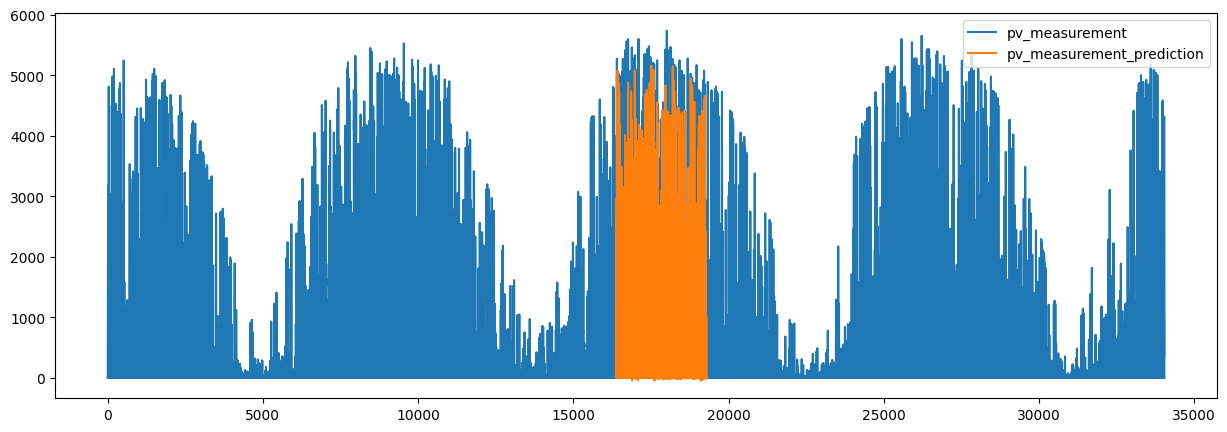

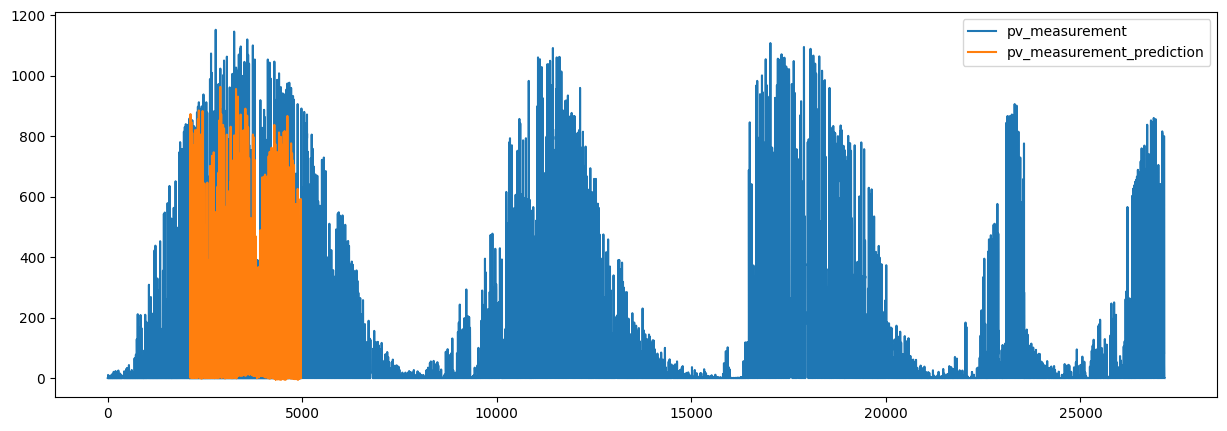

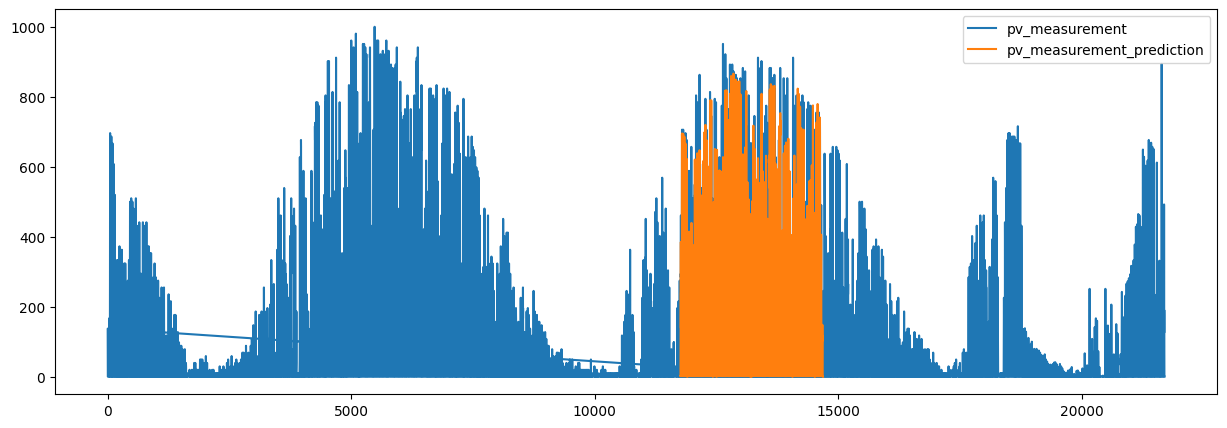

In [258]:
graph = pv_all_a[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))
graph = pv_all_b[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))
graph = pv_all_c[['pv_measurement','pv_measurement_prediction']].plot(figsize=(15, 5))

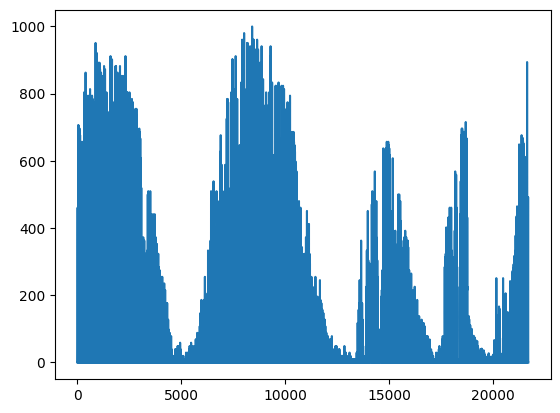

In [259]:
np_pv_c = np.array(pv_all_c['pv_measurement'])
plt.plot(np_pv_c)

# Export sur Kaggle

In [260]:
test = pd.read_csv(path+"test.csv")
test_copy = test.copy()
test.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
test["date_forecast"] = pd.to_datetime(test["date_forecast"]) #mettre le bon type

In [261]:
# Lecture des données météo associée :
merged_df_pre_a = pd.merge(X_test_estimated_a, test, on='date_forecast', how='inner')
merged_df_a = merged_df_pre_a[merged_df_pre_a["location"]=="A"]
merged_df_pre_b = pd.merge(X_test_estimated_b, test, on='date_forecast', how='inner')
merged_df_b = merged_df_pre_b[merged_df_pre_b["location"]=="B"]
merged_df_pre_c = pd.merge(X_test_estimated_c, test, on='date_forecast', how='inner')
merged_df_c = merged_df_pre_c[merged_df_pre_c["location"]=="C"]

In [262]:
def preprocessing_test(df,scaler):
  X_test = df.drop(["id","location","prediction"],axis=1)
  X_test = create_features(X_test, None)
  #X_test[('date_forecast')] = X_test[('date_forecast')].values.astype("float64")
  X_test = gestion_nan(X_test)
  X_test = sklearn_z_score_normalize_dataframe(X_test,return_scaler=False,scaler=scaler)
  return X_test

In [263]:
X_test_a_test = preprocessing_test(merged_df_a,scaler_a)
X_test_b_test = preprocessing_test(merged_df_b,scaler_b)
X_test_c_test = preprocessing_test(merged_df_c,scaler_c)

In [264]:
result_A = reg_a.predict(X_test_a_test)
result_B = reg_b.predict(X_test_b_test)
result_C = reg_c.predict(X_test_c_test)

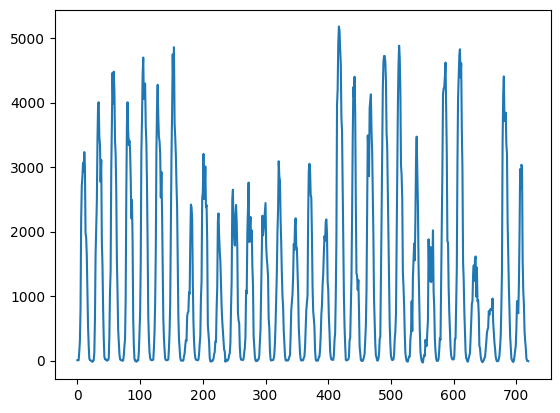

In [265]:
plt.plot(result_A)

In [266]:
nom_fichier = 'XGBoost_Valentin_V2'
repertoire = path
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

Prochaines amélioration

- mettre un minimum *Done*
- suppression des zones continues en B et C *To DO*
- prise en compte de la date (jour/mois/heure) *Done* peut être ajusté ?
- prendre le meilleur model : celui avec le meilleur score sur le deuxième testset (A : 2,8% B : 5,5%  C: 11,5%) (score eval prévu : 166) --> déjà pris en copmte dans la fonction ...


Perf V1:

A : Test 2 : 446 / 459

B : Test 2 : 101 / 107

C : Test 2 : 68 / 78

Perf V2:

A : Test 1 : 243 | Test 2 : 438 / 455

B : Test 1 : 35 | Test 2 : 106 / 110

C : Test 1 : 26 | Test 2 : 65 / 71

# Post traitement

Ici, on va faire en sorte de n'avoir que des valeurs positives (cela ne représente qu'une légère amélioration

In [267]:
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [268]:
negative_values = result[result < 0]
sum_of_negatives = np.sum(negative_values**2)/len(result)
np.sqrt(sum_of_negatives)

1.7654427373355286

In [269]:
negative_mask = result < 10
result[negative_mask] = 0

In [270]:
nom_fichier = f'XGBoost_Arthur_delta_h_{split_date_a}_{split_date_b}_and_{split_date_c}'
repertoire = path
test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)

In [271]:
result2 = np.concatenate((np.concatenate((result_A,result_B)), result_C))

In [272]:
negative_mask2 = result2 < 10
result2[negative_mask2] = 0

**Liste amélioration V2** :

- Gestion zones continues B et C (suppression)
-